In [1]:
from torch import empty
import math
from FC_module import LossMSE, ReLU, Tanh, Sigmoid, FCC, Sequential

In [2]:
train_size = 1000
test_size = 200
valid_size = 100
train_input = empty(train_size, 2).uniform_(0,1)
train_target = train_input.add(-0.5).pow(2).sum(1).sub(1 / (7)).multiply(-1).sign().add(1).div(2)

valid_input = empty(valid_size, 2).uniform_(0,1)
valid_target = valid_input.add(-0.5).pow(2).sum(1).sub(1 / (7)).multiply(-1).sign().add(1).div(2)

test_input = empty(test_size, 2).uniform_(0,1)
test_target = test_input.add(-0.5).pow(2).sum(1).sub(1 / (7)).multiply(-1).sign().add(1).div(2)

[Go to Benchamrking](#Benchmarking) with Pytorch

### These two are just for a quick check I know they are terrible :D

In [3]:
def accuracy_count(pred,true):
    pred = (pred > 0.5).long().view(-1)
    true = true.long().view(-1)
    return (pred.size(0) - (pred-true).abs().sum()).item()

In [4]:
import torch
import matplotlib.pyplot as plt

Temporary!

In [5]:
b = empty(10).uniform_(0,1).expand(5,10)
b[:,1]

tensor([0.7684, 0.7684, 0.7684, 0.7684, 0.7684])

In [6]:
b = empty(5,100).fill_(25).mean(dim = 0)
b.shape

torch.Size([100])

In [9]:
#keepdim 
#empty(a.shape).shape

In [21]:
#TODO Validation and test not correct!
#TODO Validation and test not correct!
#TODO Validation and test not correct!
#TODO Validation and test not correct!
#TODO code cleanup
#Batch and dropout and momentum test

def modelTrainer(train_input,train_target,test_input,test_target,test_size, train_batch, test_batch):
    seq = Sequential(["FCC","ReLU","FCC"],[[2,8],[], [8,1]],"MSE")
    loss_track = []
    for epoch in range(1000):
        minibatch = train_batch
        for i in range(0, train_input.size(0), minibatch):
            out,loss = seq.train(train_input.narrow(0, i, minibatch), train_target.narrow(0, i, minibatch).unsqueeze(1))
        if epoch %200 == 0:
            print("Loss:", loss.item())
        loss_track.append(loss)
    #plt.figure()
    #plt.plot(loss_track)
    print("---------------------------------")
    acc = 0
    count = 0
    minibatch = test_batch
    for i in range(0, test_size, minibatch):
        truth = test_target.narrow(0, i, minibatch)
        inp = test_input.narrow(0, i, minibatch)
        out = seq.eval(inp)
        #print(out)
        acc += accuracy_count(out, truth)
    
    return seq, acc/test_size, loss_track

In [59]:
train_size = 1000
test_size = 200
valid_size = 100
train_input = empty(train_size, 2).uniform_(0,1)
train_target = train_input.add(-0.5).pow(2).sum(1).sub(1 / (7)).multiply(-1).sign().add(1).div(2)

valid_input = empty(valid_size, 2).uniform_(0,1)
valid_target = valid_input.add(-0.5).pow(2).sum(1).sub(1 / (7)).multiply(-1).sign().add(1).div(2)

test_input = empty(test_size, 2).uniform_(0,1)
test_target = test_input.add(-0.5).pow(2).sum(1).sub(1 / (7)).multiply(-1).sign().add(1).div(2)



models = []
best_acc = 0
curr_acc = 0
best_idx = -1
loss_tracks = []
accs = []
for idx in range(100):    
    model, curr_acc, loss_track = modelTrainer(train_input,train_target,valid_input,valid_target,valid_size, 200, 10) 
    models.append(model)
    loss_tracks.append(loss_track)
    accs.append(curr_acc)
    if (curr_acc > best_acc):
        best_acc = curr_acc
        best_idx = idx
    print(curr_acc)



Loss: 0.2989724278450012
Loss: 0.23048610985279083
Loss: 0.20437797904014587
Loss: 0.17809928953647614
Loss: 0.16551275551319122
---------------------------------
0.78
Loss: 0.28098422288894653
Loss: 0.23216651380062103
Loss: 0.21939018368721008
Loss: 0.2060454934835434
Loss: 0.18712842464447021
---------------------------------
0.78
Loss: 0.4022819995880127
Loss: 0.2081635296344757
Loss: 0.17592132091522217
Loss: 0.15315502882003784
Loss: 0.11270219087600708
---------------------------------
0.94
Loss: 0.2628420889377594
Loss: 0.2058122605085373
Loss: 0.18121099472045898
Loss: 0.1607261598110199
Loss: 0.1325148195028305
---------------------------------
0.92
Loss: 0.6208791732788086
Loss: 0.20803266763687134
Loss: 0.1779017448425293
Loss: 0.1468881517648697
Loss: 0.1116933822631836
---------------------------------
0.93
Loss: 0.4204618036746979
Loss: 0.21074099838733673
Loss: 0.1849544197320938
Loss: 0.15495434403419495
Loss: 0.11600741744041443
---------------------------------
0.95


Loss: 0.20242644846439362
Loss: 0.16911539435386658
Loss: 0.12703512609004974
Loss: 0.09597966074943542
---------------------------------
0.94
Loss: 0.4930846691131592
Loss: 0.23539425432682037
Loss: 0.217930406332016
Loss: 0.20043106377124786
Loss: 0.1864151507616043
---------------------------------
0.74
Loss: 0.5889488458633423
Loss: 0.2250833958387375
Loss: 0.20051801204681396
Loss: 0.1610335409641266
Loss: 0.12192262709140778
---------------------------------
0.94
Loss: 0.2993713617324829
Loss: 0.24275070428848267
Loss: 0.24294063448905945
Loss: 0.24300891160964966
Loss: 0.24306383728981018
---------------------------------
0.57
Loss: 0.4350740909576416
Loss: 0.2348775714635849
Loss: 0.2227499783039093
Loss: 0.20781353116035461
Loss: 0.18315382301807404
---------------------------------
0.8
Loss: 0.4309729039669037
Loss: 0.2144988626241684
Loss: 0.17082321643829346
Loss: 0.11853007227182388
Loss: 0.09050431847572327
---------------------------------
0.94
Loss: 0.4075441062450409
L

Loss: 0.22177380323410034
Loss: 0.202954962849617
Loss: 0.18415547907352448
Loss: 0.1727573275566101
---------------------------------
0.76
Loss: 0.6104763150215149
Loss: 0.23511606454849243
Loss: 0.2055186778306961
Loss: 0.1818629652261734
Loss: 0.1698905974626541
---------------------------------
0.74


In [74]:
acc_sort = np.argsort(accs)
colors = plt.cm.jet(np.linspace(.7,1.,100))

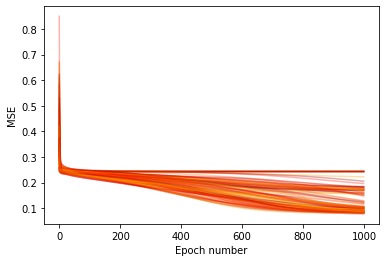

In [82]:
for i in acc_sort:
    plt.plot(loss_tracks[i], color = colors[i], label = round(100*accs[i]), alpha=1/3)
plt.xlabel('Epoch number')
plt.ylabel('MSE');

In [62]:
final_losses = [loss_tracks[i][-1] for i in range(100)]

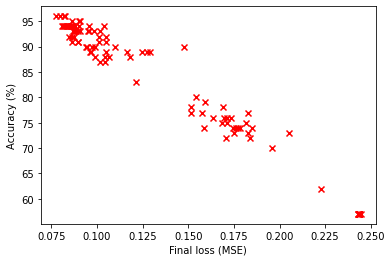

In [89]:
plt.scatter(final_losses, 100*np.array(accs), marker='x', color='r')
plt.xlabel('Final loss (MSE)')
plt.ylabel('Accuracy (%)');

In [12]:
best_idx

5

In [13]:
test_target

tensor([0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
        0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.,
        0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0.,
        1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0.,
        0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1.,
        1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
        0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
        1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
        1., 0.])

### Benchmarking

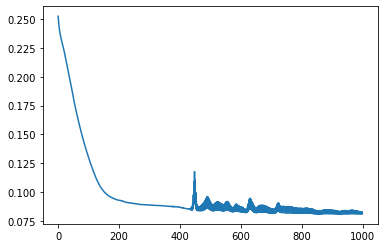

In [15]:
from torch import optim, Tensor, nn
from torch import Tensor
from torch import nn
import torch
import numpy as np
import matplotlib.pyplot as plt
torch.set_grad_enabled(True)

def create_model():
    return nn.Sequential(
        nn.Linear(2, 8),
        nn.ReLU(),
        nn.Linear(8, 1)
    )

def train_model(model, train_input, train_target):
    loss_track = []
    loss_func = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr = 0.1)
    mini_batch = 200
    # Iterate through epochs
    for i in range(1000):
        #Iterate t hrough mini batches
        for b in range(0, train_input.size(0), mini_batch):
            # Forward pass selecting the corresponding minibacth
            output = model(train_input.narrow(0, b, mini_batch))
            # Calculate loss
            loss = loss_func(output.squeeze(), train_target.narrow(0, b, mini_batch))
#             print("Loss:", loss.item())
            # Reset zero grad
            model.zero_grad()
            # Backward pass
            loss.backward()
            #Update step
            optimizer.step()
        loss_track.append(loss)
    plt.plot(loss_track)
    
def compute_nb_errors(model, data_input, data_target):
        output = model(data_input)
        comp = output.argmax(dim = 1) != data_target.argmax(dim = 1)
        nb_errors = torch.where(comp)[0].size()[0]
        error_rate = nb_errors/data_input.size(0)
        print(f'There were a total of {nb_errors} errors, or {error_rate} of the testing set.')
        
        
model = create_model()
train_model(model, train_input, train_target)
# compute_nb_errors(model, test_input, test_target)